# Anchor Boxes Analysis using K-Means

Ce code est extrait et adapté de : 
https://github.com/joydeepmedhi/Anchor-Boxes-with-KMeans/blob/master/EDA%20of%20bbox.ipynb.
Il a pour objectf de déterminer par clustering les tailles et ratios est boites 'anchor' utilisées par faster rcnn.

### Section 1

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

### with Image resizing (correct way!)

#### Read csv
A csv was made from xml file using "xml_to_csv.py"

In [53]:
#Read the dataset
data = pd.read_csv('/tf/ship_data/train_ship_segmentations_OD.csv')
data = data[data.xmax == data.xmax]

#utility function to get width & height
def change_to_wh (data):
    data['w'] = data['xmax'] - data['xmin'] + 1
    data['h'] = data['ymax'] - data['ymin'] + 1
    return data

min_dimension = 600
max_dimension = 1024

# function from Tensorflow Object Detection API to resize image
def _compute_new_static_size(width, height, min_dimension, max_dimension):
    orig_height = height
    orig_width = width
    orig_min_dim = min(orig_height, orig_width)
  
    # Calculates the larger of the possible sizes
    large_scale_factor = min_dimension / float(orig_min_dim)
      # Scaling orig_(height|width) by large_scale_factor will make the smaller
      # dimension equal to min_dimension, save for floating point rounding errors.
      # For reasonably-sized images, taking the nearest integer will reliably
      # eliminate this error.
    large_height = int(round(orig_height * large_scale_factor))
    large_width = int(round(orig_width * large_scale_factor))
    large_size = [large_height, large_width]
    if max_dimension:
    # Calculates the smaller of the possible sizes, use that if the larger
    # is too big.
        orig_max_dim = max(orig_height, orig_width)
        small_scale_factor = max_dimension / float(orig_max_dim)
    # Scaling orig_(height|width) by small_scale_factor will make the larger
    # dimension equal to max_dimension, save for floating point rounding
    # errors. For reasonably-sized images, taking the nearest integer will
    # reliably eliminate this error.
        small_height = int(round(orig_height * small_scale_factor))
        small_width = int(round(orig_width * small_scale_factor))
        small_size = [small_height, small_width]
        new_size = large_size
    if max(large_size) > max_dimension:
        new_size = small_size
    else:
        new_size = large_size
    
    return new_size[1], new_size[0]

In [54]:
# Initial Data
data.describe()

,Unnamed: 0.1,Unnamed: 0,width,height,xmin,ymin,xmax,ymax
count,81713.000000,81713.000000,81713.0,81713.0,81713.000000,81713.000000,81713.000000,81713.000000
mean,115834.929815,115834.929815,768.0,768.0,357.935628,362.691677,409.439502,405.403804
std,66858.754692,66858.754692,0.0,0.0,216.605407,217.775228,216.364008,217.371162
min,2.000000,2.000000,768.0,768.0,0.000000,0.000000,3.000000,3.000000
25%,58237.000000,58237.000000,768.0,768.0,170.000000,174.000000,224.000000,219.000000
50%,115455.000000,115455.000000,768.0,768.0,356.000000,361.000000,411.000000,406.000000
75%,173993.000000,173993.000000,768.0,768.0,542.000000,550.000000,598.000000,595.000000
max,231714.000000,231714.000000,768.0,768.0,765.000000,764.000000,768.000000,768.000000


In [55]:
data = change_to_wh(data)
data['new_w'], data['new_h'] = np.vectorize(_compute_new_static_size)(data['width'], 
                                                                      data['height'], min_dimension, max_dimension)
data['b_w'] = data['new_w']*data['w']/data['width']
data['b_h'] = data['new_h']*data['h']/data['height']
data['b_ar'] = data['b_w']/data['b_h']

### Calculate the base box size!


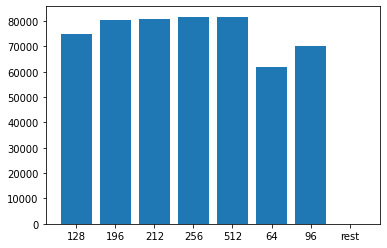

In [56]:
def count_base_size(width, height, input_array=[64,96,128,196,212,256,512]):
    result = {}
    for ele in input_array:
        result[str(ele)] = 0
    result['rest'] = 0
    
    import itertools
    for w,h in zip(width,height):
        done = False
        for inp in input_array:
            if w <= inp and h <= inp:
                result[str(inp)] += 1
                done = True
        if done == False:
            result['rest'] += 1
            
    return result
    
D = count_base_size(data["b_w"].tolist(), data["b_h"].tolist())
import collections
OD = collections.OrderedDict(sorted(D.items()))
plt.bar(range(len(OD)), OD.values(), align='center')  # python 2.x
plt.xticks(range(len(OD)), OD.keys())  # in python 2.x

plt.show()


In [57]:
print(OD)

OrderedDict([('128', 74827), ('196', 80245), ('212', 80801), ('256', 81598), ('512', 81713), ('64', 61851), ('96', 70144), ('rest', 0)])


In [58]:
# Area Scale
base_box = 256*256
data['b_area_scale'] = (data['w']*data['h']/(base_box)).apply(np.sqrt)
data.describe()

,Unnamed: 0.1,Unnamed: 0,width,height,xmin,ymin,xmax,ymax,w,h,new_w,new_h,b_w,b_h,b_ar,b_area_scale
count,81713.000000,81713.000000,81713.0,81713.0,81713.000000,81713.000000,81713.000000,81713.000000,81713.000000,81713.000000,81713.0,81713.0,81713.000000,81713.000000,81713.000000,81713.000000
mean,115834.929815,115834.929815,768.0,768.0,357.935628,362.691677,409.439502,405.403804,52.503873,43.712127,600.0,600.0,41.018651,34.150099,1.345686,0.177479
std,66858.754692,66858.754692,0.0,0.0,216.605407,217.775228,216.364008,217.371162,57.055710,45.436130,0.0,0.0,44.574774,35.496976,0.900944,0.172479
min,2.000000,2.000000,768.0,768.0,0.000000,0.000000,3.000000,3.000000,2.000000,2.000000,600.0,600.0,1.562500,1.562500,0.129032,0.011719
25%,58237.000000,58237.000000,768.0,768.0,170.000000,174.000000,224.000000,219.000000,14.000000,14.000000,600.0,600.0,10.937500,10.937500,0.750000,0.056607
50%,115455.000000,115455.000000,768.0,768.0,356.000000,361.000000,411.000000,406.000000,29.000000,26.000000,600.0,600.0,22.656250,20.312500,1.076923,0.113214
75%,173993.000000,173993.000000,768.0,768.0,542.000000,550.000000,598.000000,595.000000,70.000000,57.000000,600.0,600.0,54.687500,44.531250,1.666667,0.234765
max,231714.000000,231714.000000,768.0,768.0,765.000000,764.000000,768.000000,768.000000,444.000000,336.000000,600.0,600.0,346.875000,262.500000,9.050000,1.089592


In [59]:
# TF scale
base_anchor = 256
data['tf_scale'] = data['b_h']*(data['b_ar']).apply(np.sqrt)/base_anchor
data['tf_scale_2']= data['b_w']/((data['b_ar']).apply(np.sqrt)*base_anchor)
data.describe()

,Unnamed: 0.1,Unnamed: 0,width,height,xmin,ymin,xmax,ymax,w,h,new_w,new_h,b_w,b_h,b_ar,b_area_scale,tf_scale,tf_scale_2
count,81713.000000,81713.000000,81713.0,81713.0,81713.000000,81713.000000,81713.000000,81713.000000,81713.000000,81713.000000,81713.0,81713.0,81713.000000,81713.000000,81713.000000,81713.000000,81713.000000,81713.000000
mean,115834.929815,115834.929815,768.0,768.0,357.935628,362.691677,409.439502,405.403804,52.503873,43.712127,600.0,600.0,41.018651,34.150099,1.345686,0.177479,0.138656,0.138656
std,66858.754692,66858.754692,0.0,0.0,216.605407,217.775228,216.364008,217.371162,57.055710,45.436130,0.0,0.0,44.574774,35.496976,0.900944,0.172479,0.134749,0.134749
min,2.000000,2.000000,768.0,768.0,0.000000,0.000000,3.000000,3.000000,2.000000,2.000000,600.0,600.0,1.562500,1.562500,0.129032,0.011719,0.009155,0.009155
25%,58237.000000,58237.000000,768.0,768.0,170.000000,174.000000,224.000000,219.000000,14.000000,14.000000,600.0,600.0,10.937500,10.937500,0.750000,0.056607,0.044224,0.044224
50%,115455.000000,115455.000000,768.0,768.0,356.000000,361.000000,411.000000,406.000000,29.000000,26.000000,600.0,600.0,22.656250,20.312500,1.076923,0.113214,0.088448,0.088448
75%,173993.000000,173993.000000,768.0,768.0,542.000000,550.000000,598.000000,595.000000,70.000000,57.000000,600.0,600.0,54.687500,44.531250,1.666667,0.234765,0.183410,0.183410
max,231714.000000,231714.000000,768.0,768.0,765.000000,764.000000,768.000000,768.000000,444.000000,336.000000,600.0,600.0,346.875000,262.500000,9.050000,1.089592,0.851244,0.851244


In [60]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'filename', 'width', 'height', 'class',
       'xmin', 'ymin', 'xmax', 'ymax', 'w', 'h', 'new_w', 'new_h', 'b_w',
       'b_h', 'b_ar', 'b_area_scale', 'tf_scale', 'tf_scale_2'],
      dtype='object')

## Clusterring

### Eucledian Distance Based Clusterring

### One by One (AR and Scale Separately)

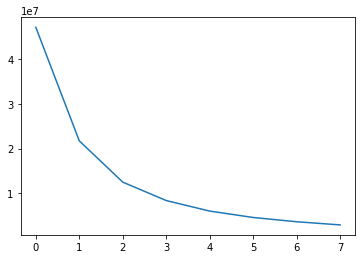

In [61]:
# Aspect Ratio
X = data.iloc[:,14].values
X = X.reshape(-1,1)


loss = []
from sklearn.cluster import KMeans
for i in range(2,10):
    K = KMeans(i, random_state=1)
    labels = K.fit(X)
    loss.append(labels.inertia_)

plt.plot(loss)

In [62]:
print(data.columns[14])

from sklearn.cluster import KMeans
K = KMeans(3, random_state=1)
labels = K.fit(X)
print("Aspect Ratios:\n")
print(labels.cluster_centers_)

b_w
Aspect Ratios:

[[ 16.6904804 ]
 [155.27530665]
 [ 65.13175535]]


In [63]:
# Correlation Check (ignore!)

x = data['w']/data['h']

data['b_ar'].corr(x)

0.9999999999999999

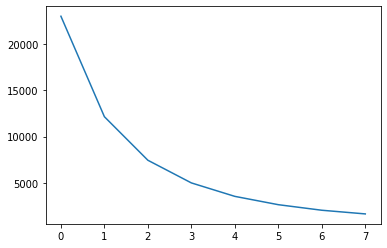

In [64]:
# TF_Scale Clusterring
X = data.iloc[:,16].values
X = X.reshape(-1,1)


loss = []
from sklearn.cluster import KMeans
for i in range(2,10):
    K = KMeans(i, random_state=1)
    labels = K.fit(X)
    loss.append(labels.inertia_)

plt.plot(loss)

In [65]:
print(data.columns)
print(data.columns[16])

from sklearn.cluster import KMeans
K = KMeans(1, random_state=1)
labels = K.fit(X)
labels.cluster_centers_

Index(['Unnamed: 0.1', 'Unnamed: 0', 'filename', 'width', 'height', 'class',
       'xmin', 'ymin', 'xmax', 'ymax', 'w', 'h', 'new_w', 'new_h', 'b_w',
       'b_h', 'b_ar', 'b_area_scale', 'tf_scale', 'tf_scale_2'],
      dtype='object')
b_ar


array([[1.34568587]])

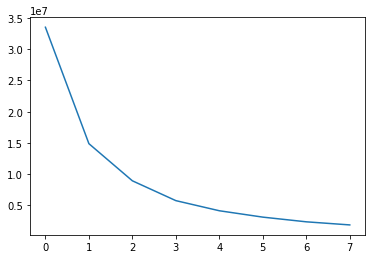

In [66]:
# area_Scale
X = data.iloc[:,15].values
X = X.reshape(-1,1)


loss = []
from sklearn.cluster import KMeans
for i in range(2,10):
    K = KMeans(i, random_state=1)
    labels = K.fit(X)
    loss.append(labels.inertia_)

plt.plot(loss)

In [67]:
print(data.columns[15])

from sklearn.cluster import KMeans
K = KMeans(4, random_state=1)
labels = K.fit(X)
labels.cluster_centers_

b_h


array([[ 44.46771578],
       [158.03061548],
       [ 13.87787074],
       [ 87.72747872]])

### IOU based clusterring

In [68]:
#utility functions for K-means
import numpy as np


def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [69]:
print(data.columns[12:14])

X = data.iloc[:, 12:14].values


# Cluster with 4 centers
cl = kmeans(X, 4)
print(cl)

Index(['new_w', 'new_h'], dtype='object')
[[600 600]
 [600 600]
 [600 600]
 [600 600]]


In [70]:
ar_iou = cl[:,0]/cl[:,1]

print(ar_iou)


scale_iou = cl[:,1]*np.sqrt(ar_iou)/256
print(scale_iou)

[1. 1. 1. 1.]
[2.34375 2.34375 2.34375 2.34375]
